In [129]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [130]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [131]:
print(device)

cuda


In [132]:
from google.colab import drive
drive.mount('/content/test')


Drive already mounted at /content/test; to attempt to forcibly remount, call drive.mount("/content/test", force_remount=True).


In [133]:
transformer=transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [134]:
batch_size = 16
num_classes = 3
learning_rate = 0.001
num_epochs = 10

In [135]:
train_path='/content/test/MyDrive/train'
test_path='/content/test/MyDrive/test'
validation_path = '/content/test/MyDrive/validation'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=16, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=16, shuffle=True
)

validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_path,transform=transformer),
    batch_size=16, shuffle=True
)

In [136]:
test_loader.dataset[0][0].shape

torch.Size([3, 227, 227])

In [137]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [138]:
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


In [139]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [140]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

model = AlexNet(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [141]:
import numpy as np
epochs = 30
min_valid_loss = np.inf
val_losses = []
train_losses = []
for e in range(epochs):
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = model(data)
        loss = criterion(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
  

    model.eval()     # Optional when not using Model Specific layer
    for data, labels in validation_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)
        
 

    train_losses.append((train_loss / len(train_loader)))
    val_losses.append((valid_loss / len(validation_loader)))


    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')


Epoch 1 		 Training Loss: 2.7757191923948437 		 Validation Loss: 0.6492822700076633
Validation Loss Decreased(inf--->5.843540) 	 Saving The Model
Epoch 2 		 Training Loss: 0.985345184803009 		 Validation Loss: 0.5811279349856906
Validation Loss Decreased(5.843540--->5.230151) 	 Saving The Model
Epoch 3 		 Training Loss: 0.9487640179120578 		 Validation Loss: 0.48085106743706596
Validation Loss Decreased(5.230151--->4.327660) 	 Saving The Model
Epoch 4 		 Training Loss: 0.8585895740068876 		 Validation Loss: 0.10394360456201765
Validation Loss Decreased(4.327660--->0.935492) 	 Saving The Model
Epoch 5 		 Training Loss: 0.7757912709162785 		 Validation Loss: 0.5527899000379775
Epoch 6 		 Training Loss: 0.7303199121585259 		 Validation Loss: 0.24610143568780687
Epoch 7 		 Training Loss: 0.7474796214928994 		 Validation Loss: 0.18722416626082528
Epoch 8 		 Training Loss: 0.7310443738332162 		 Validation Loss: 0.25856415430704754
Epoch 9 		 Training Loss: 0.7271936882000704 		 Validation Lo

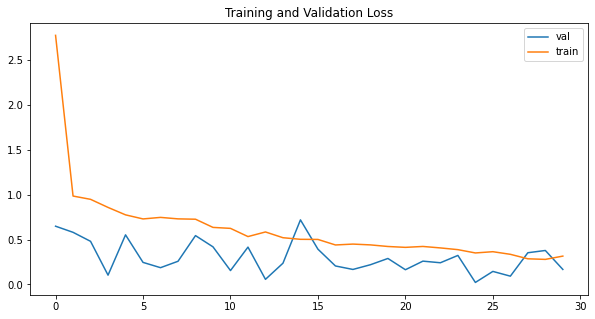

[0.6492822700076633, 0.5811279349856906, 0.48085106743706596, 0.10394360456201765, 0.5527899000379775, 0.24610143568780687, 0.18722416626082528, 0.25856415430704754, 0.5445379018783569, 0.4192182421684265, 0.15502345230844286, 0.4164063599374559, 0.05729177759753333, 0.2369598216480679, 0.719720721244812, 0.3931185272004869, 0.20631442467371622, 0.16750824120309618, 0.22004630830552843, 0.2898605333434211, 0.16434884733623928, 0.2599984241856469, 0.2420746452278561, 0.3235928879843818, 0.022655742035971746, 0.14559474256303576, 0.0927271114455329, 0.35369141234291923, 0.37876003318362766, 0.1675872670279609]


In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.legend()
plt.show()


print(val_losses)

In [143]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [144]:
print(train_count,test_count)

1034 128


In [145]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

model = AlexNet(num_classes=3).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [147]:
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm

total_step = len(train_loader)
for epoch in range(13):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 15 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, 7, i+1, total_step, loss.item()))
                       
y_true = []
y_pred = []

for data in tqdm(test_loader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())
 
  outputs=model(images)
 
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())
f1_score(y_true, y_pred, average='macro')
print(f1_score(y_true, y_pred, average='macro'))

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
	 

Epoch [1/7], Step [15/65], Loss: 1.0471
Epoch [1/7], Step [30/65], Loss: 0.7241
Epoch [1/7], Step [45/65], Loss: 0.7761
Epoch [1/7], Step [60/65], Loss: 0.8231
Epoch [2/7], Step [15/65], Loss: 0.3817
Epoch [2/7], Step [30/65], Loss: 0.6227
Epoch [2/7], Step [45/65], Loss: 0.6521
Epoch [2/7], Step [60/65], Loss: 0.5989
Epoch [3/7], Step [15/65], Loss: 0.4763
Epoch [3/7], Step [30/65], Loss: 0.6224
Epoch [3/7], Step [45/65], Loss: 0.4828
Epoch [3/7], Step [60/65], Loss: 0.8773
Epoch [4/7], Step [15/65], Loss: 0.8447
Epoch [4/7], Step [30/65], Loss: 0.5650
Epoch [4/7], Step [45/65], Loss: 0.6077
Epoch [4/7], Step [60/65], Loss: 0.4720
Epoch [5/7], Step [15/65], Loss: 0.5481
Epoch [5/7], Step [30/65], Loss: 0.3945
Epoch [5/7], Step [45/65], Loss: 0.9499
Epoch [5/7], Step [60/65], Loss: 0.5338
Epoch [6/7], Step [15/65], Loss: 0.7220
Epoch [6/7], Step [30/65], Loss: 0.5706
Epoch [6/7], Step [45/65], Loss: 0.5254
Epoch [6/7], Step [60/65], Loss: 0.6450
Epoch [7/7], Step [15/65], Loss: 0.6048


100%|██████████| 8/8 [00:01<00:00,  6.17it/s]


0.8192588438290347
Accuracy of the network on the 10000 test images: 82.03125 %


In [148]:
import sklearn.metrics

print("f1 score",f1_score(y_true, y_pred, average='macro'))
print("f1 score",f1_score(y_true, y_pred, average='micro'))
print("accuracy_score",sklearn.metrics.accuracy_score(y_true, y_pred))
print("balanced accuracy_score",sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
print("precision_score",sklearn.metrics.precision_score(y_true, y_pred, average='macro'))
print("rECALL micro",sklearn.metrics.recall_score(y_true, y_pred, average='micro'))
print("rECALL macro",sklearn.metrics.recall_score(y_true, y_pred, average='macro'))

f1 score 0.8192588438290347
f1 score 0.8203125
accuracy_score 0.8203125
balanced accuracy_score 0.8207825765965301
precision_score 0.8190131124913734
rECALL micro 0.8203125
rECALL macro 0.8207825765965301


100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


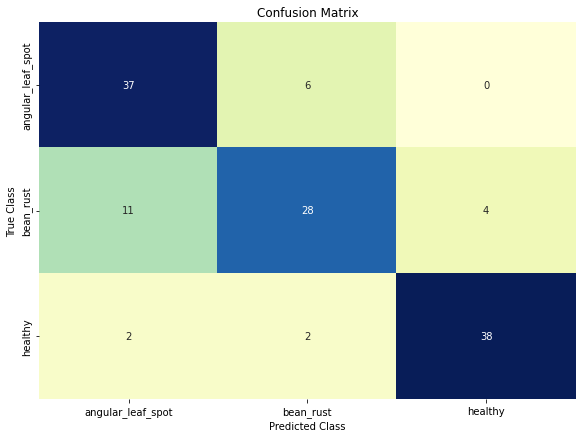

In [149]:
import seaborn as sns
from tqdm import tqdm
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
 
for data in tqdm(test_loader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())
 
  outputs=model(images)
 
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())


cf_matrix = confusion_matrix(y_true, y_pred)

class_names = ('angular_leaf_spot', 'bean_rust', 'healthy')
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)


plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()